<img src="./img/metro_madrid.jpg" alt="drawing" width="500"/>

# Transporte y renta en la Comunidad de Madrid

### TEMA

Este proyecto busca arrojar luz sobre los patrones de comportamiento en el transporte de los ciudadanos de la Comunidad de Madrid, estudiando posibles vínculos con su renta. Para ello, se utiliza la [Encuesta de Movilidad del Consorcio Regional](https://datos.comunidad.madrid/dataset/resultados-edm2018) de Transportes de Madrid (CRTM), realizada en el 2018.

Para los cálculos de la renta, se utilizan diferentes tablas extraídas de la [Encuesta de Condiciones de Vida](https://ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176807&menu=ultiDatos&idp=1254735976608) del INE, para el año 2018

### HIPÓTESIS

La hipótesis principal de este proyecto es que **existe una relación entre la renta y el uso del transporte en la Comunidad de Madrid**. En concreto, se buscará contrastar:
+ Si las rentas más altas eligen el coche como primera opción para desplazamientos laborales y por placer.
+ Las rentas bajas, para trabajar, utilizan más el transporte público que el coche.
+ Las mujeres utilizan más el transporte público para desplazamientos laborales, sin tener en cuenta la renta.
    + Lo que, unido al segundo punto, explicaría que las mujeres no usan más el transporte público por deseo sino por necesidad.
+ Los hombres utilizan más el transporte privado para desplazamientos por placer


### SUPUESTOS
Dados los datos utilizados, hemos de tener en cuenta varios puntos:
+ Se está utilizando la última encuesta publicada por el CRTM (en serio).
    + Sí se cuentan con los datos de uso del Metro de Madrid, que en 2023 volvieron a niveles pre-pandemia. Por tanto, podemos suponer que no han cambiado las pautas de comportamiento en un nivel agregado
+ No contamos con la renta de los encuestados. Para ello generaremos un dato *proxy*, que estimaremos en función de las condiciones socioeconómicas de los encuestados (edad, ocupación, género, grado de educación, y si cuenta con coche).
    + Renta != Riqueza. Estimaremos la cantidad de **generar** , no de **poseer**. Una persona sin trabajo pero con patrimonio no quedará reflejada en este estudio.
    + Por disponibilidad de los datos, se utilizarán las medias de las rentas. En función de disponibilidad de los datos, es posible que se recoja la media española en lugar de la de la Comunidad de Madrid.
+ Los datos sólo tienen en cuenta días estrictamente laborales (Lunes-Jueves)
+ Si bien no tiene impacto a primera vista sobre las hipótesis, se realizará un estudio de impacto de la **meteorología** sobre el uso de unos u otros medios transportes.


## OBTENCIÓN DE LOS DATOS

### DATASETS Y FUENTES ALTERNATIVAS DE DATOS

In [2]:
import hashlib
import requests
import datetime
import pandas as pd
import numpy as np

In [30]:

### TODO: Pasar las Aux a utils
### Importar openpyxl
# guarda en variables los datasets y su fuente
# df_transpk = pd.DataFrame(pd.read_csv("./data/raw/kaggle_public_transp.csv"))
# fuente_1a = "https://www.kaggle.com/datasets/dataguapa/madrid-public-transportation-data-2018"

### MAIN

df_transp_ind = pd.DataFrame(pd.read_excel("./data/raw/EDM2018INDIVIDUOS.xlsx", sheet_name = 'INDIVIDUOS'))
fuente_1 = "https://datos.comunidad.madrid/dataset/resultados-edm2018"

df_transp_trp = pd.DataFrame(pd.read_excel("./data/raw/EDM2018VIAJES.xlsx", sheet_name = 'VIAJES'))
fuente_1 = "https://datos.comunidad.madrid/dataset/resultados-edm2018"


### AUX

df_hogares = pd.DataFrame(pd.read_csv("./data/raw/ine_gasto_hogares.csv", sep=";"))
fuente_2 = "https://www.ine.es/jaxiT3/Tabla.htm?t=24900"

df_ingresos = pd.DataFrame(pd.read_csv("./data/raw/ine_madrid_fuentes_ingreso.csv",sep=";"))
fuente_3 = "https://ine.es/jaxiT3/Tabla.htm?t=53687"

df_renta_es = pd.DataFrame(pd.read_csv("./data/raw/ine_renta_edad_sexo.csv",encoding='latin1',sep=";"))
fuente_4 = "https://ine.es/jaxiT3/Tabla.htm?t=9942"

df_educacion = pd.DataFrame(pd.read_excel("./data/raw/ine_renta_educacion.xlsx", sheet_name="educación",skiprows=2,index_col=0,nrows=5)) ### Terminar de apañar
fuente_5 = "https://ine.es/ss/Satellite?c=INESeccion_C&cid=1259944504067&p=1254735110672&pagename=ProductosYServicios%2FPYSLayout&param1=PYSDetalleFichaIndicador&param3=1259937499084"

In [72]:
df_transp = pd.DataFrame(pd.read_csv("./data/treated/transp.csv"))

In [184]:
### Extracts income of women and men by age, consolidates it into a single dataframe and creates a normalized index with the values
df_men_age = pd.DataFrame(pd.read_excel("./data/raw/ecv19.xlsx", sheet_name="2.1.1",skiprows=19,index_col=1,nrows=5,header=None))
df_women_age = pd.DataFrame(pd.read_excel("./data/raw/ecv19.xlsx", sheet_name="2.1.1",skiprows=26,index_col=1,nrows=5,header=None))
df_gender_age = pd.concat([df_men_age.iloc[:,1],df_women_age.iloc[:,1]],axis=1, keys=["men","women"])
df_gender_age = round(((df_gender_age-np.nanmean(df_gender_age))/np.nanstd(df_gender_age)+1),2) ### np.nanmean takes the mean of the whole df
df_gender_age

,men,women
1,,
Menos de 16 años,-0.18,-0.36
De 16 a 29 años,0.17,-0.04
De 30 a 44 años,1.63,0.83
De 45 a 64 años,2.61,2.11
65 años o más,1.65,1.57


In [183]:
### Extracts income by education and creates a normalized index with the values
df_educ = pd.DataFrame(pd.read_excel("./data/raw/ecv19.xlsx", sheet_name="2.1.2",skiprows=11,index_col=1,nrows=4,header=None)).iloc[:,1]
df_educ = round(((df_educ-df_educ.mean())/df_educ.std()+1),2)
df_educ

1
Educación primaria o inferior    0.27
Educación secundaria 1ª etapa    0.55
Educación secundaria 2ª etapa    0.70
Educación superior               2.48
Name: 2, dtype: float64

In [186]:
### Extracts income by occupation and creates a normalized index with the values
df_ocup = pd.DataFrame(pd.read_excel("./data/raw/ecv19.xlsx", sheet_name="2.1.3",skiprows=11,index_col=1,nrows=4,header=None)).iloc[:,1]
df_ocup = round(((df_ocup-df_ocup.mean())/df_ocup.std()+1),2)
df_ocup

1
Ocupados           1.67
Parados           -0.06
Jubilados          2.02
Otros inactivos    0.37
Name: 2, dtype: float64

In [72]:
from utils import utils as ut
import numpy as np
import pandas as pd
import matplotlib as plt

df_gender_age, df_educ, df_occup = ut.aux_data_extraction()
df_transp = pd.read_csv("./data/treated/transp.csv")


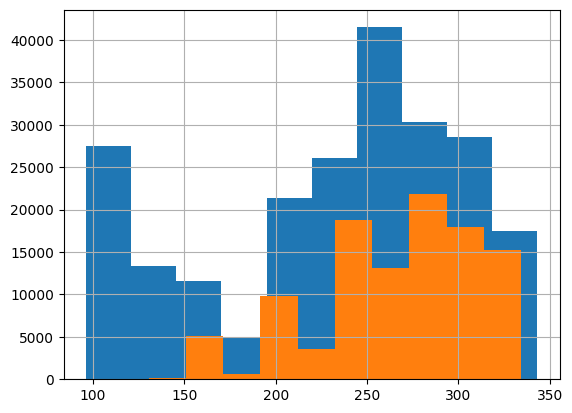

In [74]:
###TODO: get the hists right
plt.figure
inc_hist = df_transp['income'].hist()
inc_hist.get_figure().savefig('./img/plots/hists/income.png')
plt.figure
worker_inc_hist = df_transp[df_transp['activity'] == "worker"]['income'].hist()
worker_inc_hist.get_figure().savefig('./img/plots/hists/workers_income.png')



In [75]:
df_transp.groupby('income')['id_indiv'].count()

income
96.25         6
98.00      9799
103.25       73
105.00     1036
107.00    13400
          ...  
301.75      328
309.25    17926
318.00     1671
334.25    15199
343.00     2323
Name: id_indiv, Length: 122, dtype: int64